<a href="https://colab.research.google.com/github/pinakm9/sphere-fp/blob/master/data/4D/sphere4D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required modules**

In [1]:
# run this cell to download data and necessary modules
import os, shutil
repo = 'sphere-fp'
if os.path.isdir(repo):
  shutil.rmtree(repo)
!git clone https://github.com/pinakm9/sphere-fp.git
# add modules folder to Python's search path
import sys
sys.path.insert(0, repo + '/modules')
# import the necessary modules
import numpy as np
import tensorflow as tf
import lss_solver as lss
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Cloning into 'sphere-fp'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 177 (delta 13), reused 44 (delta 9), pack-reused 121
Receiving objects: 100% (177/177), 49.41 MiB | 30.32 MiB/s, done.
Resolving deltas: 100% (47/47), done.


**Define the equation through the $\mathcal L_{\log}$ operator**

In [2]:
DTYPE = tf.float32
D = 1.0
dim = 4
ones = np.ones(dim)
domain = [-2. * ones, 2. * ones]
save_folder = '{}/data/{}D'.format(repo, dim)

@tf.function
def diff_log_op(f, x, y, x1, y1):
    z = 4.*(x**2 + y**2 - 1.) 
    z1 = 4.*(x1**2 + y1**2 - 1.)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y, x1, y1])
        f_ = f(x, y, x1, y1)
        f_x, f_y, f_x1, f_y1 = tape.gradient(f_, [x, y, x1, y1])
    f_xx = tape.gradient(f_x, x)
    f_yy = tape.gradient(f_y, y)
    f_x1x1 = tape.gradient(f_x1, x1)
    f_y1y1 = tape.gradient(f_y1, y1)
    return z*(x*f_x + y*f_y) + z1*(x1*f_x1 + y1*f_y1) + 4.*(z+ z1 + dim) + D*(f_x**2 + f_y**2 + f_xx + f_yy + f_x1**2 + f_y1**2 + f_x1x1 + f_y1y1) 

**Define the steady state $p_\infty(\mathbf x)$**

In [3]:
from scipy.special import erf
import numpy as np

def p_inf2(x, y):
  Z = 0.5 * np.sqrt(np.pi**3 * D) * (1. + erf(1/np.sqrt(D)))
  return tf.exp(-(x**2 + y**2 - 1.)**2 / D) / Z 

def p_inf(x, y, x1, y1):
  return p_inf2(x, y) * p_inf2(x1, y1)

**Set up experiment parameters and learn the stationary distribution**

In [4]:
learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 2000, 10000], [5e-3, 1e-3, 5e-4, 1e-4])
optimizer = tf.keras.optimizers.Adam(learning_rate)
solver = lss.LogSteadyStateSolver(num_nodes=50, num_blocks=3, dtype=DTYPE, name='sphere{}D'.format(dim), diff_log_op=diff_log_op, optimizer=optimizer, domain=domain)
solver.learn(epochs = 800000, n_sample = 1000, save_folder=save_folder)

Streaming output truncated to the last 5000 lines.
750000    0.010394        21086.3721
750010    0.009356        21086.6547
750020    0.010157        21086.9285
750030    0.010100        21087.2055
750040    0.010292        21087.5052
750050    0.009884        21087.7839
750060    0.009483        21088.0569
750070    0.010118        21088.3342
750080    0.010873        21088.6083
750090    0.010173        21088.8907
750100    0.010490        21089.1690
750110    0.010650        21089.4498
750120    0.009904        21089.7240
750130    0.009679        21089.9973
750140    0.010483        21090.2781
750150    0.009494        21090.5725
750160    0.010147        21090.8453
750170    0.010129        21091.1199
750180    0.009840        21091.3927
750190    0.010779        21091.6820
750200    0.010426        21091.9573
750210    0.010257        21092.2539
750220    0.010111        21092.5486
750230    0.010074        21092.8356
750240    0.010117        21093.1084
750250    0.010526      

**Visualize the learned distribution**

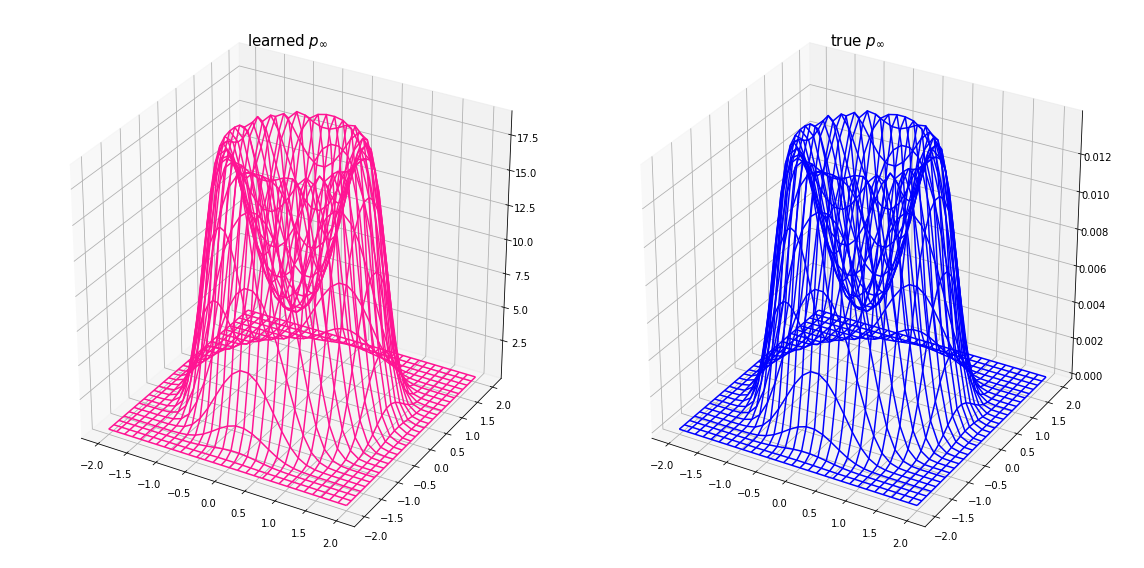

In [5]:
import matplotlib.pyplot as plt

def plot_solutions(learned, true, resolution=30, low=[-2., -2, -2., -2], high=[2., 2., 2., 2.]):
  fig = plt.figure(figsize=(16, 8))
  ax_l = fig.add_subplot(121, projection='3d')
  ax_t = fig.add_subplot(122, projection='3d')
  x = np.linspace(low[0], high[0], num=resolution, endpoint=True).astype('float32')
  y = np.linspace(low[1], high[1], num=resolution, endpoint=True).astype('float32')
  y = np.repeat(y, resolution, axis=0).reshape((-1, 1))
  x = np.array(list(x) * resolution).reshape((-1, 1))
  z_l = learned(x, y).numpy()
  z_t = true(x, y).numpy()
  grid = (resolution, resolution)
  x = x.reshape(grid)
  y = y.reshape(grid)
  z_l = z_l.reshape(grid)
  z_t = z_t.reshape(grid)
  ax_l.plot_wireframe(x, y, z_l, color='deeppink')
  ax_l.set_title('learned $p_\infty$', fontsize=15)
  ax_t.plot_wireframe(x, y, z_t, color='blue')
  ax_t.set_title('true $p_\infty$', fontsize=15)
  plt.tight_layout()
  plt.show()
  

plot_solutions(learned=lambda x, y: tf.exp(solver.net(x, y, tf.zeros_like(x), tf.zeros_like(x))), true=lambda x, y: p_inf(x, y, tf.zeros_like(x), tf.zeros_like(x)))

**Investigate the size of $θ$**

In [6]:
solver.net.summary()

Model: "sphere4D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTMForgetBlock (LSTMForget  multiple                 1800      
 Block)                                                          
                                                                 
 LSTMForgetBlock (LSTMForget  multiple                 11000     
 Block)                                                          
                                                                 
 LSTMForgetBlock (LSTMForget  multiple                 11000     
 Block)                                                          
                                                                 
 dense (Dense)               multiple                  51        
                                                                 
 batch_normalization (BatchN  multiple                 0 (unused)
 ormalization)                                            